In [1]:
!pip install openpyxl
!pip install pandarallel
!pip install pyarrow

In [147]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import matplotlib.pyplot as plt

DATA_ROOT_FOLDER =  "../data"

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [148]:
# import read data from xlsx in pandas,
# rotate and use first row as header
def read_xlsx(path):
    df = pd.read_excel(path, engine='openpyxl')
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    # drop index
    df = df.reset_index(drop=True)

    return df

# read data
df_y_train = read_xlsx(f"{DATA_ROOT_FOLDER}/raw/Y_train.xlsx")
df_y_train.head()

"ИПЦ, мом",Период,Целевой показатель
0,2020-06-01 00:00:00,0.28
1,2020-07-01 00:00:00,-0.065
2,2020-08-01 00:00:00,-0.005
3,2020-09-01 00:00:00,0.315
4,2020-10-01 00:00:00,0


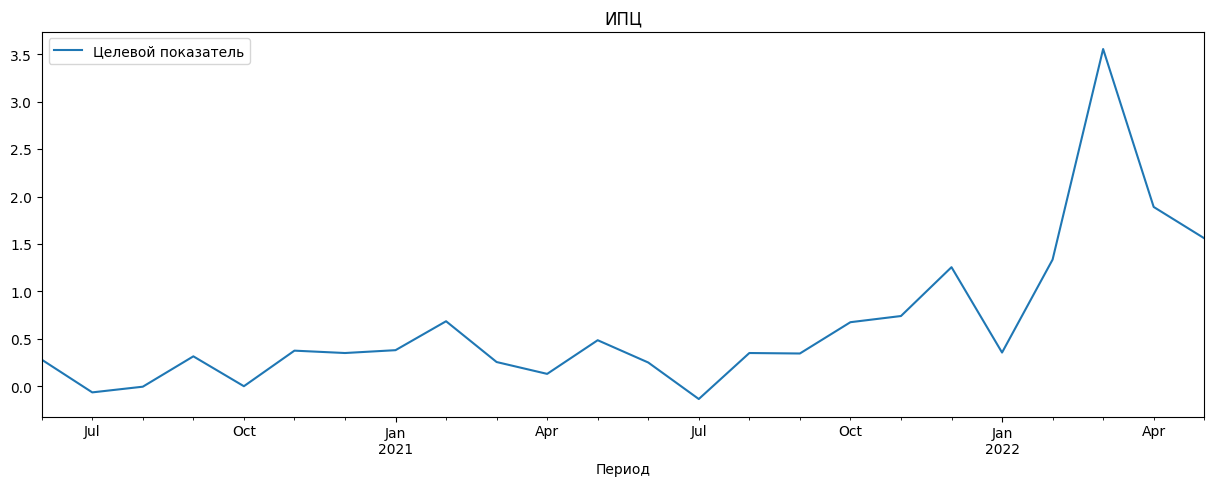

In [149]:
# plot target variable
df_y_train.plot(x='Период', y='Целевой показатель', title='ИПЦ', figsize=(15, 5))
plt.show()

In [150]:
# unrar training data in data/raw
# !unrar x {DATA_ROOT_FOLDER}/raw/DS_train.rar {DATA_ROOT_FOLDER}/raw/DS_train/

In [151]:
!du -sh {DATA_ROOT_FOLDER}/raw/DS_train

3.1G	../data/raw/DS_train


In [152]:
# import read data from xlsx in pandas
df_db = pd.read_csv(f"{DATA_ROOT_FOLDER}/raw/DS_train/DS_train(2020-06--2022-06-01).csv", sep="\t", engine="pyarrow")
df_db.head()

,WebPriceId,DateObserve,StockStatus,CurrentPrice
0,1,2020-06-25 19:23:21.010,InStock,49.0
1,1,2020-09-08 07:39:23.593,OutOfStock,NaN
2,1,2020-09-08 15:39:01.663,InStock,49.0
3,1,2020-09-08 23:42:25.007,OutOfStock,NaN
4,1,2020-09-09 07:38:41.163,InStock,49.0


In [153]:
df_db.shape

(69173886, 4)

In [154]:
df_db.head()

,WebPriceId,DateObserve,StockStatus,CurrentPrice
0,1,2020-06-25 19:23:21.010,InStock,49.0
1,1,2020-09-08 07:39:23.593,OutOfStock,NaN
2,1,2020-09-08 15:39:01.663,InStock,49.0
3,1,2020-09-08 23:42:25.007,OutOfStock,NaN
4,1,2020-09-09 07:38:41.163,InStock,49.0


In [155]:
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69173886 entries, 0 to 69173885
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   WebPriceId    int64         
 1   DateObserve   datetime64[ns]
 2   StockStatus   object        
 3   CurrentPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.1+ GB


In [156]:
# Test preprocess pipeline

# df_db_preprocess_test = df_db[:100].copy()


# from datetime import datetime
# def datestr_to_datetime(datetime_string: str) -> datetime:
#     return datetime.strptime(datetime_string, "%Y-%m-%d %H:%M:%S.%f")

# df_db_preprocess_test["Date"] = df_db_preprocess_test["DateObserve"].apply(datestr_to_datetime)
# df_db_preprocess_test.drop(columns=["DateObserve"], inplace=True)
# df_db_preprocess_test.head()

# df_db["Date"] = df_db_preprocess_test["DateObserve"].apply(datestr_to_datetime)
# df_db.drop(columns=["DateObserve"], inplace=True)
# df_db.head(10)


<AxesSubplot:title={'center':'Количество товаров в группе'}>

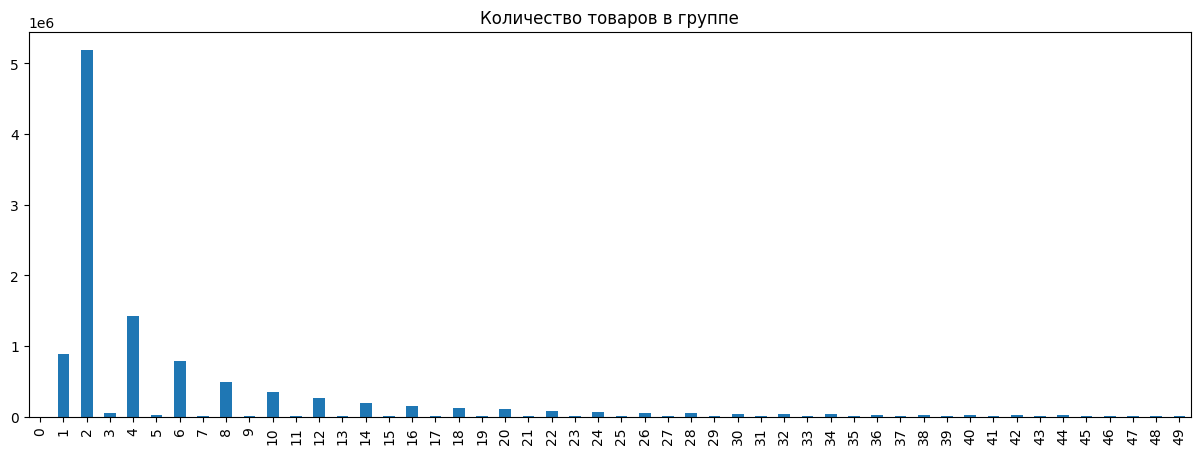

In [157]:

a = df_db.groupby("WebPriceId").count()['CurrentPrice'].sort_values(ascending=False).value_counts().sort_index()[:50]
a.plot(kind='bar', title='Количество товаров в группе', figsize=(15, 5))


In [158]:
a

0          12
1      885152
2     5190183
3       51055
4     1425303
5       20655
6      790413
7       11324
8      491174
9        8051
10     351010
11       6246
12     255866
13       5018
14     195870
15       4175
16     154482
17       3543
18     124794
19       3244
20     100072
21       2831
22      81390
23       2343
24      67408
25       2087
26      56237
27       1923
28      47580
29       1629
30      40187
31       1421
32      34754
33       1392
34      30110
35       1336
36      26417
37       1196
38      22830
39       1141
40      20087
41       1034
42      17330
43       1002
44      15354
45        979
46      13371
47       1017
48      11890
49        829
Name: CurrentPrice, dtype: int64

In [159]:
# 
df_db_count = df_db[df_db["DateObserve"] >= '2021-01-01'].groupby("WebPriceId").count()
df_db_count


,DateObserve,StockStatus,CurrentPrice
WebPriceId,,,
2,8,8,8
3,12,12,12
4,20,20,20
5,1,1,1
6,1,1,1
...,...,...,...
11571459,2,2,2
11571460,2,2,2
11571461,2,2,2


In [160]:
df_db_count[df_db_count['CurrentPrice'] >= 0].index.shape[0] / df_db_count.index.shape[0]

1.0

In [161]:
percentiles = []
for entries_count in range(0, 150):
    valid_series_idx = df_db_count[df_db_count['CurrentPrice'] >= entries_count].index
    percentiles.append(len(valid_series_idx)/len(df_db_count))

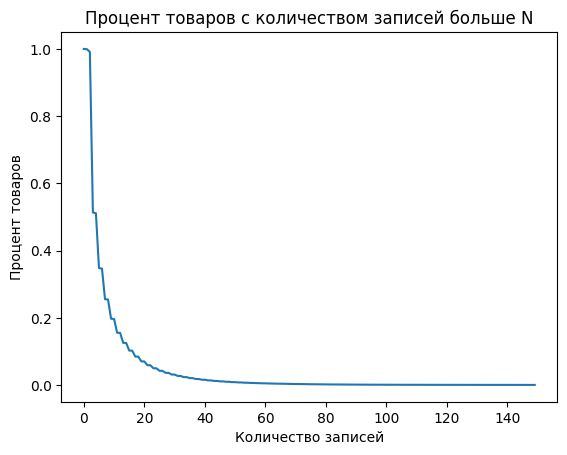

In [162]:
plt.title("Процент товаров с количеством записей больше N")
plt.xlabel("Количество записей")
plt.ylabel("Процент товаров")
plt.plot(percentiles)


In [163]:
percentiles[-1:]

[0.0001272334593807181]

In [164]:
df_db_count.shape[0]

7419432

In [165]:
df_db_count[df_db_count['CurrentPrice'] >= 30].index.shape[0]

229778

In [166]:
df_db_count[df_db_count['CurrentPrice'] >= 30].index.shape[0] / df_db_count.index.shape[0]


0.03096975617540534

In [167]:
df_db_count[df_db_count['CurrentPrice'] >= 365].index.shape[0]


21

In [168]:
df_db_count[df_db_count['StockStatus'] >= 360].index.shape[0]


21

In [169]:
df_db_count[df_db_count['CurrentPrice'] >= 120].index.shape[0]


2547

In [170]:
df_db_count[df_db_count['CurrentPrice'] >= 120].index.shape[0] / df_db_count.shape[0]


0.0003432877341553909

In [171]:
df_db_count[df_db_count['CurrentPrice'] >= 60].index.shape[0]


36158

In [172]:
df_db_count.shape[0]

7419432

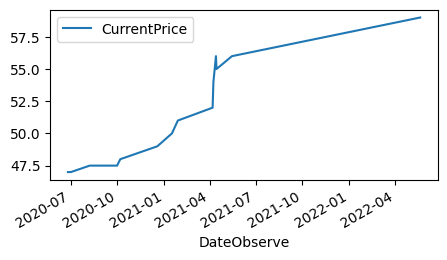

In [126]:
# Select items with WebPriceId == 1 and StockStatus == "InStock"
def select_item_series(df_db: pd.DataFrame, item_id: int) -> pd.DataFrame:
    sample_series = df_db[(df_db["WebPriceId"] == item_id) & (df_db["StockStatus"] == "InStock")].copy()
    sample_series.drop(columns=["WebPriceId", "StockStatus"], inplace=True)
    return sample_series


# plot item series with webpriceId 1
sample_series = select_item_series(df_db, 2)
sample_series.plot(x="DateObserve", y="CurrentPrice", figsize=(5, 2.5))
plt.show()

In [127]:
items_count = df_db[df_db["StockStatus"] == "InStock"].groupby("WebPriceId").count().shape[0]
print(f"Number of items: {items_count}")

entries_count = df_db.shape[0]
print(f"Number of entries: {entries_count}")

# print average number of entries per item
print(f"Average number of entries per item: {entries_count/items_count}")


Number of items: 10666479
Number of entries: 69173886
Average number of entries per item: 6.485165910887745


In [173]:
def select_df_by_entries_count(df_db: pd.DataFrame, entries_count: int) -> pd.DataFrame:
    df_db_count = df_db.groupby("WebPriceId").count()
    valid_series_idx = df_db_count[df_db_count['CurrentPrice'] > entries_count].index
    return df_db[df_db["WebPriceId"].isin(valid_series_idx)]


df_db = select_df_by_entries_count(df_db[df_db["DateObserve"] >= '2021-01-01'], 60)

In [174]:
df_db.head(50)

,WebPriceId,DateObserve,StockStatus,CurrentPrice
2788,112,2021-01-12 07:38:39.433,InStock,574.000000
2789,112,2021-01-19 18:45:36.000,InStock,643.000000
2790,112,2021-01-25 18:39:09.000,InStock,603.000000
2791,112,2021-01-28 10:46:26.487,InStock,608.000000
2792,112,2021-02-01 18:56:03.000,InStock,597.000000
2793,112,2021-02-10 15:32:25.520,InStock,596.000000
2794,112,2021-02-13 07:33:44.957,InStock,665.000000
2795,112,2021-04-05 13:44:32.000,InStock,623.000000
2796,112,2021-04-08 13:42:40.000,InStock,665.000000
2797,112,2021-04-13 13:44:27.000,InStock,699.000000


In [175]:
df_db.shape

(2839795, 4)

In [176]:
# For each nan in current price, interpolate value from previous and next values, do it by webpriceid
from joblib import Parallel, delayed
import multiprocessing

def tmpFunc(df):
    df['c'] = df.a + df.b
    return df

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

def interpolate_nan(df_db: pd.DataFrame) -> pd.DataFrame:
    df_db["CurrentPrice"] = applyParallel(df_db.groupby("WebPriceId")["CurrentPrice"], lambda x: x.interpolate(method='linear'))
    return df_db

sample_df = df_db[:1000000].copy()
sample_df['CurrentPrice'][34] = None
sample_df = interpolate_nan(sample_df)
sample_df.head(50)

/tmp/ipykernel_1869893/3908946709.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['CurrentPrice'][34] = None


,WebPriceId,DateObserve,StockStatus,CurrentPrice
2788,112,2021-01-12 07:38:39.433,InStock,574.000000
2789,112,2021-01-19 18:45:36.000,InStock,643.000000
2790,112,2021-01-25 18:39:09.000,InStock,603.000000
2791,112,2021-01-28 10:46:26.487,InStock,608.000000
2792,112,2021-02-01 18:56:03.000,InStock,597.000000
2793,112,2021-02-10 15:32:25.520,InStock,596.000000
2794,112,2021-02-13 07:33:44.957,InStock,665.000000
2795,112,2021-04-05 13:44:32.000,InStock,623.000000
2796,112,2021-04-08 13:42:40.000,InStock,665.000000
2797,112,2021-04-13 13:44:27.000,InStock,699.000000


In [177]:
%%time
# df_db["CurrentPrice"] = applyParallel(df_db.groupby("WebPriceId")["CurrentPrice"], lambda x: x.interpolate(method='linear'))
print(df_db.head().isna().sum())

WebPriceId      0
DateObserve     0
StockStatus     0
CurrentPrice    0
dtype: int64
CPU times: user 1.8 ms, sys: 153 µs, total: 1.96 ms
Wall time: 1.9 ms


In [178]:
df_db.to_csv(f"{DATA_ROOT_FOLDER}/processed/ds_X_train_interpolated.csv", sep="\t", index=False)

: 

/tmp/ipykernel_119181/226794341.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_prices = new_prices.append([new_prices.iloc[-1]] * (extrapolate_to - 1), ignore_index=True)


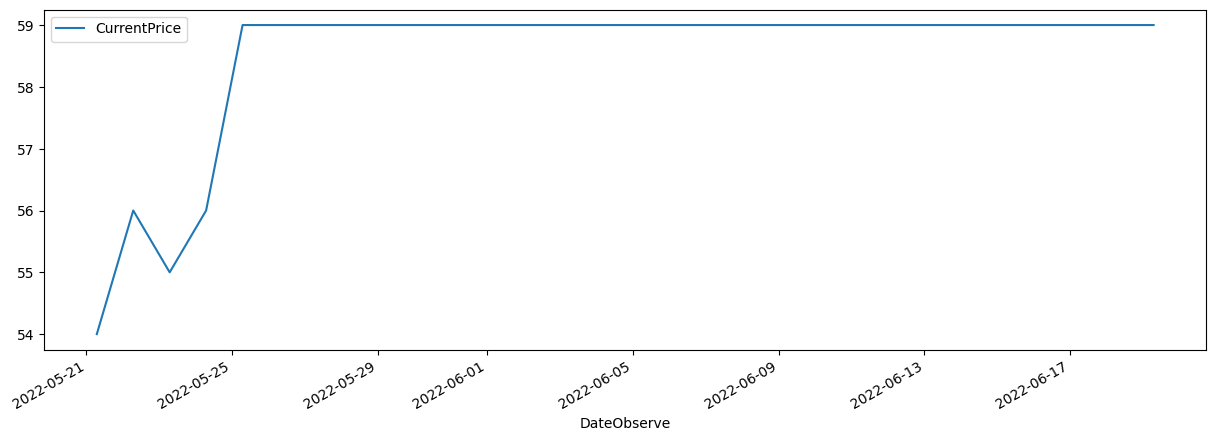

In [162]:
# Forecast time series depending on last 5 values
def forecast_series(series: pd.DataFrame, extrapolate_to: int) -> pd.DataFrame:
    # get last 5 prices
    last_5_price = series["CurrentPrice"].iloc[-5:]
    # get last 5 dates
    last_5_date = series["DateObserve"].iloc[-5:]

    # create new dataframe with extrapolated dates
    new_dates = pd.date_range(last_5_date.iloc[-1], periods=extrapolate_to, freq="D")
    new_dates = pd.DataFrame(new_dates, columns=["DateObserve"])

    # create new dataframe with extrapolated prices
    new_prices = pd.DataFrame(last_5_price, columns=["CurrentPrice"])
    new_prices = new_prices.append([new_prices.iloc[-1]] * (extrapolate_to - 1), ignore_index=True)

    # merge new dates and prices
    new_series = pd.concat([new_dates, new_prices], axis=1)
    return new_series



# Plot Extraploated series
sample_series = select_item_series(df_db, 2)
sample_series = forecast_series(sample_series, 30)
sample_series.plot(x="DateObserve", y="CurrentPrice", figsize=(15, 5))
plt.show()

In [ ]:
# Use RGBM model to extrapolate time series
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

